In [4]:
import pandas as pd
import pingouin as pg
import scipy.stats as scipy
import seaborn as sns
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

plt.style.use('ggplot')

# 1-я часть
1. Проверьте, являются ли дисперсии внутри групп гомогенными.
2. Проведите тест на нормальность распределения.
3. Сравните средние в представленных группах.
4. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.
5. Примите решение: какие картинки в итоге будем использовать?

# 1.Проверьте, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными). Это делается с помощью теста Левена. Для этого отсортируем группы в отдельные датафреймы и эти датафреймы превратим в серии (массивоподобные элементы). Далее скормим эти массивы тесту Левана через scipy.stats.levene либо pingouin.homoscedasticity

In [5]:
df = pd.read_csv ('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev-19/Статистика/5 урок/5_task_1.csv')
df.head(3)

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30


In [6]:
a = df.query('group == "A"')
b = df.query('group == "B"')
c = df.query('group == "C"')

In [7]:
a = pd.Series(a.events)
b = pd.Series(b.events)
c = pd.Series(c.events)

In [8]:
scipy.levene(a, b, c, center='median', proportiontocut=0.05)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

p-уровень больше 0,05. Значит не отклоняем нулевую гипотезу

# 2. Также убедитесь, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты. Для воспроизводимости результата используйте параметр random_state=17 в методе sample. Дополнительно: попробуйте посчитать тест Шапиро-Уилка без использования метода sample. Сравните  результат с normaltest, а также qq-графиками. Какой вывод можно сделать по совокупности этих методов?

In [9]:
scipy.shapiro(a.sample(n = 1000, random_state=17))
# a.sample(n = 1000, random_state=17) - это оставляем в выборке 1000 наблюдений
# scipy.shapiro - это тест шапиро-вилка. Повторяем для всех трех выборок
# р-уровень выше 0.05, поэтому не отклоняем нулевую гипотезу о нормальности. Распределение нормальное

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [10]:
scipy.shapiro(b.sample(n = 1000, random_state=17))

ShapiroResult(statistic=0.9980798363685608, pvalue=0.31768906116485596)

In [11]:
scipy.shapiro(c.sample(n = 1000, random_state=17))

ShapiroResult(statistic=0.9981185793876648, pvalue=0.3359004259109497)

# 3. Сравните средние в представленных группах. Это делается с помощью однофакторного дисперсионного анализа. Однофакторный т.к. сравниваем только среднее

In [12]:
scipy.f_oneway(a, b, c)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

р-уровень 0, поэтому отклоняем гипотезу о равенстве средних.
Средние хотябы между двумя группами значимо различаются

# 4. Используйте критерий Тьюки и определите, между какими группами есть статистически значимые различия.

Делается это тремя способами

- from statsmodels.stats.multicomp import (pairwise_tukeyhsd, MultiComparison)
- print(pairwise_tukeyhsd(столбец_с_данными, столбец_с_обозначениями_групп))

или

- MultiComp = MultiComparison(столбец_с_данными, столбец_с_обозначениями_групп)
- print(MultiComp.tukeyhsd().summary())

- group1 и group2 — названия групп, которые сравниваются в рамках теста
- meandiff — разница между значением 2 группы и значением 1 группы
- p-adj — скорректированный порог значимости
- lower и upper — нижняя и верхняя границы доверительного интервала различий в средних
- reject — отвергается нулевая гипотеза или нет. True - отвергается нулевая гипотеза о том что средние в группах не различаются.
Как видно по последней колонке, все нулевые гипотезы были отклонены, поэтому мы делаем вывод, что средние всех трёх групп значимо различаются.

или

- pg.pairwise_tukey(data=данные, dv="зависимая_переменная", between="независимая_переменная")
- Если наши группы имеют разную дисперсию, то применяется критерий Геймса-Хоувелла:
- pg.pairwise_gameshowell(data=данные, dv="зависимая_переменная", between="независимая_переменная")

In [13]:
print(pairwise_tukeyhsd(df.events, df.group))
#True - отвергается нулевая гипотеза о том что средние в группах не различаются.

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj  lower    upper  reject
----------------------------------------------------
     A      B    8.034 0.001   7.7038  8.3642   True
     A      C  -2.1093 0.001  -2.4395 -1.7791   True
     B      C -10.1433 0.001 -10.4735 -9.8131   True
----------------------------------------------------


# 5. Примите решение: какие картинки в итоге будем использовать?

Построил боксплот и посмотрел. У группы В больше ивентов

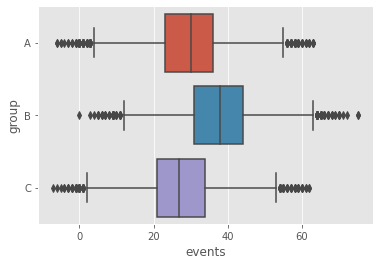

In [14]:
sns.boxplot(data=df, x="events", y="group")

# 2-я часть
- Выберите метод для второго теста
- Визуализируйте распределение events для контрольной и тестовой групп
- Посмотрите на описательные статистики events в разбивке по группе и по сегменту пользователя
- Выберите формулу для модели, проведите тест

In [15]:
df2 = pd.read_csv ('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev-19/Статистика/5 урок/5_task_2.csv')
df2.head(3)

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


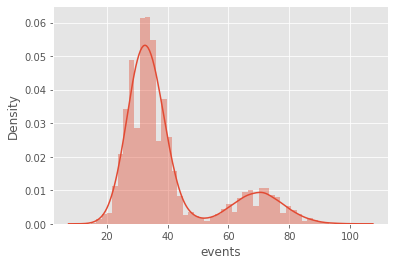

In [16]:
# Строим график для тестовой и контрольной групп. чтобы сопоставить в ЛМС что к чему относится.
# sns ругается что дисплот устареет и просит поменять код - игнорируем

sns.distplot(df2.query('group == "test"').events)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


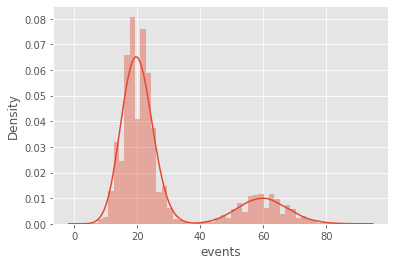

In [17]:
sns.distplot(df2.query('group == "control"').events)

In [18]:
df2 \
    .groupby(['group', 'segment']) \
    .describe()

# смотрим events - std  чтобы узнать стандартное отклонение

id                                                     \
                   count        mean           std   min       25%      50%   
group   segment                                                               
control high     10000.0  50473.9782  28761.438914  10.0  25612.50  51031.0   
        low      40000.0  49935.2567  28855.849243   0.0  25022.25  49944.5   
test    high     10000.0  50126.6206  28821.133487  14.0  25317.50  50234.5   
        low      40000.0  49913.3436  28917.383492   1.0  24763.75  49706.5   

                                     events                                   \
                      75%      max    count       mean       std   min   25%   
group   segment                                                                
control high     75261.25  99976.0  10000.0  59.970800  7.805347  31.0  55.0   
        low      74874.25  99999.0  40000.0  20.031575  4.473576   4.0  17.0   
test    high     74783.25  99996.0  10000.0  69.938500  8.403974  40.0  64.0   
        low      75127.25  99995.0  40000.0  33.025925  5.720845  13.0  29.0   

                                    
                  50%   75%    max  
group   segment                     
control high     60.0  65.0   89.0  
        low      20.0  23.0   41.0  
test    high     70.0  76.0  102.0  
        low      33.0  37.0   59.0

In [19]:
formula = 'events ~ group + segment + group:segment'
model = ols(formula, df2).fit()
aov_table = anova_lm(model, typ=2)

In [20]:
aov_table

,sum_sq,df,F,PR(>F)
group,3.837195e+06,1.0,112031.864119,0.000000e+00
segment,2.362480e+07,1.0,689756.377484,0.000000e+00
group:segment,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


In [21]:
pg.anova(data=df2, dv="events", between=["group", "segment"])

,Source,SS,DF,MS,F,p-unc,np2
0,group,3.837195e+06,1.0,3.837195e+06,112031.864119,0.000000e+00,0.528383
1,segment,2.362480e+07,1.0,2.362480e+07,689756.377484,0.000000e+00,0.873383
2,group * segment,3.664244e+04,1.0,3.664244e+04,1069.823273,2.060261e-233,0.010585
3,Residual,3.424956e+06,99996.0,3.425093e+01,NaN,NaN,NaN


In [22]:
df2 ['combination'] = df2['group'] + ' \ ' + df2['segment']

In [23]:
pairwise_tukeyhsd(df2.events, df2.combination).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.001,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.001,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.001,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.001,49.7388,50.075,True
control \ low,test \ low,12.9944,0.001,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.001,-37.0807,-36.7445,True


Разница между control/high и test/high составила около 10
Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13

Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой
так как control \ low 	 test \ low - положительный meandiff
      и control \ high	test \ high - тоже положительный meandiff

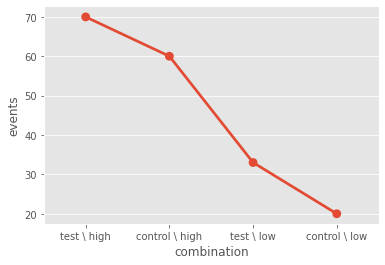

In [24]:
sns.pointplot(data=df2, x='combination', y='events')

Фактор group оказался ЗНАЧИМЫМ, фактор segment – ЗНАЧИМЫМ, их взаимодействие – ЗНАЧИМО.
Судя по графику, для всех групп среднее значение events УВЕЛИЧИЛОСЬ, поэтому решение: 
ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ

# 3-я часть (Бутстрап)
- Бутстрап позволяет многократно извлекать подвыборки из выборки, полученной в рамках экспериментва
- В полученных подвыборках считаются статистики (среднее, медиана и т.п.)
- Из статистик можно получить ее распределение и взять доверительный интервал
- ЦПТ, например, не позволяет строить доверительные интервал для медианы, а бутстрэп это может сделать

In [27]:
df3 = pd.read_csv ('/mnt/HC_Volume_18315164/home-jupyter/jupyter-a-altynbaev-19/Статистика/9 урок/hw_bootstrap.csv', sep = ';')
df3 = df3.rename(columns={'Unnamed: 0': 'number'})
df3.head(3)

,number,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control


In [29]:
Control = df3.query('experimentVariant == "Control"').value
Control = Control.apply(lambda x: float(x.replace(',', '.')))

In [30]:
Treatment = df3.query('experimentVariant == "Treatment"').value
Treatment = Treatment.apply(lambda x: float(x.replace(',', '.')))

In [31]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data),
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

In [33]:
# будем пробовать бутстрап на эксп. распределении
np.random.seed(5)

n = 10000
lift = 1.01

x = np.random.exponential(size=n)
y = np.random.exponential(size=n) * lift

df3 = pd.DataFrame({"x": x, "y": y})

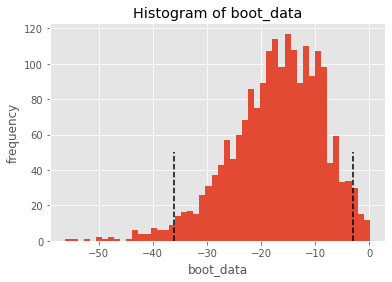

In [34]:
booted_data = get_bootstrap(Control, Treatment, boot_it = 2000, statistic = np.mean) # в результате хранится разница двух распределений, ДИ и pvalue

In [35]:
booted_data["p_value"]

0.04391237720934501

In [36]:
booted_data["ci"]

,0
0.025,-35.998357
0.975,-2.984069


In [37]:
res = mannwhitneyu(Control, Treatment, alternative="two-sided")
print(res)

MannwhitneyuResult(statistic=124189.5, pvalue=0.8592148582485579)


- p_value по np.median - 0.902
- p_value по np.mean - 0.038
- p_value по Mannwhitneyu - 0.859

Можем отвергнуть нулевую гипотезу о раверстве средних, но не о равенстве медиан